# Подготовка

In [70]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from statsmodels.tsa.seasonal import seasonal_decompose

import os

Выгружаем датасет

In [71]:
BASE_DIR = os.getcwd()

In [72]:
# INDEX_BTCUSD, 720 - 12h tf
df = pd.read_csv(f'{BASE_DIR}/datasets/BTC-USD(4).csv')

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    4846 non-null   object 
 1   open    4846 non-null   float64
 2   high    4846 non-null   float64
 3   low     4846 non-null   float64
 4   close   4846 non-null   float64
dtypes: float64(4), object(1)
memory usage: 189.4+ KB


In [74]:
df['time'] = pd.to_datetime(df['time'])

In [75]:
df = df.set_index(df['time']).drop('time', axis=1)
df = df.drop(['open','high','low'], axis=1)
df = df.astype('float')

In [76]:
df_d = df[['close']]

<AxesSubplot:xlabel='time'>

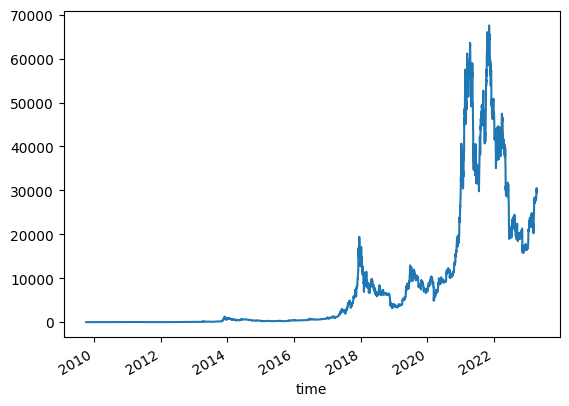

In [77]:
df_d['close'].plot(kind='line')

## Заменяем индексацию

Заменяем индексацию по времени на индексацию по блокам

In [78]:
blocks = pd.read_csv(f'{BASE_DIR}/datasets/GLASSNODE_BTC_BLOCKS, 1D.csv')
blocks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5212 entries, 0 to 5211
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   time    5212 non-null   object
 1   open    5212 non-null   int64 
 2   high    5212 non-null   int64 
 3   low     5212 non-null   int64 
 4   close   5212 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 203.7+ KB


In [79]:
#удаляем лишние столбцы
blocks['time'] = pd.to_datetime(blocks['time'])
blocks = blocks.set_index(blocks['time']).drop('time', axis=1)
blocks = blocks.drop(['open','high','low'], axis=1)
blocks = blocks.astype('float')
blocks['close2'] = blocks['close']
blocks = blocks.drop(['close'], axis=1)

Объединяем цену и количество блоков по времени

In [80]:
df_b =df.join(blocks, how='inner')
df_b.rename(columns={'close2': 'time'}, inplace=True)
df_b

,close,time
time,,
2009-10-05 00:00:00+00:00,0.000764,24418.0
2009-10-06 00:00:00+00:00,0.000885,24461.0
2009-10-07 00:00:00+00:00,0.001050,24521.0
2009-10-08 00:00:00+00:00,0.001084,24591.0
2009-10-09 00:00:00+00:00,0.001200,24671.0
...,...,...
2023-04-13 00:00:00+00:00,30407.470000,785290.0
2023-04-14 00:00:00+00:00,30495.030000,785430.0
2023-04-15 00:00:00+00:00,30324.640000,785588.0


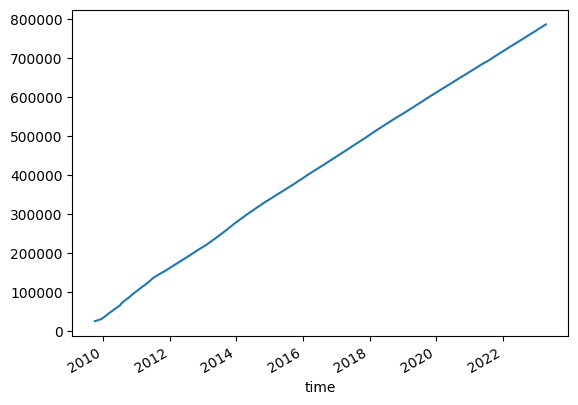

In [81]:
df_b['time'].plot(kind='line');

Меняем индексацию по времени на индексацию по блокам

In [82]:
df_b.set_index('time', inplace=True)

<AxesSubplot:xlabel='time'>

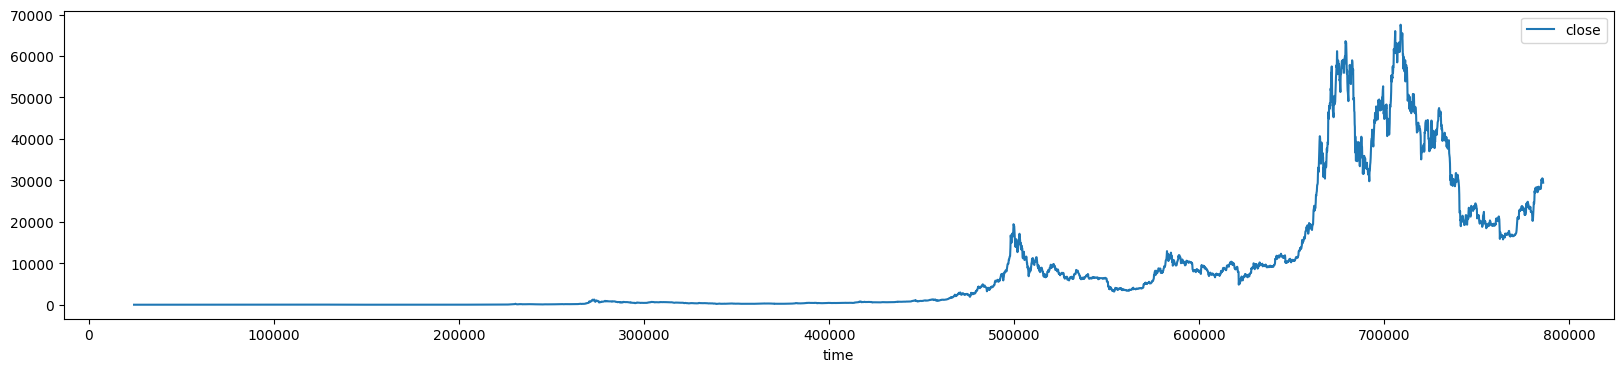

In [83]:
df_b.plot(kind='line', figsize = (20,4))

In [84]:
df_b

,close
time,
24418.0,0.000764
24461.0,0.000885
24521.0,0.001050
24591.0,0.001084
24671.0,0.001200
...,...
785290.0,30407.470000
785430.0,30495.030000
785588.0,30324.640000


## Метод Бокса-Кокса

In [85]:
from scipy import stats

In [86]:
df_box = pd.DataFrame(df_b.copy())
df_box['close'], box_cox_lambda = stats.boxcox(df_b['close'])

In [87]:
box_cox_lambda

0.13134561458013058

In [88]:
df_box

,close
time,
24418.0,-4.647397
24461.0,-4.589728
24521.0,-4.520697
24591.0,-4.507774
24671.0,-4.465977
...,...
785290.0,21.926072
785430.0,21.937231
785588.0,21.915491


<AxesSubplot:xlabel='time'>

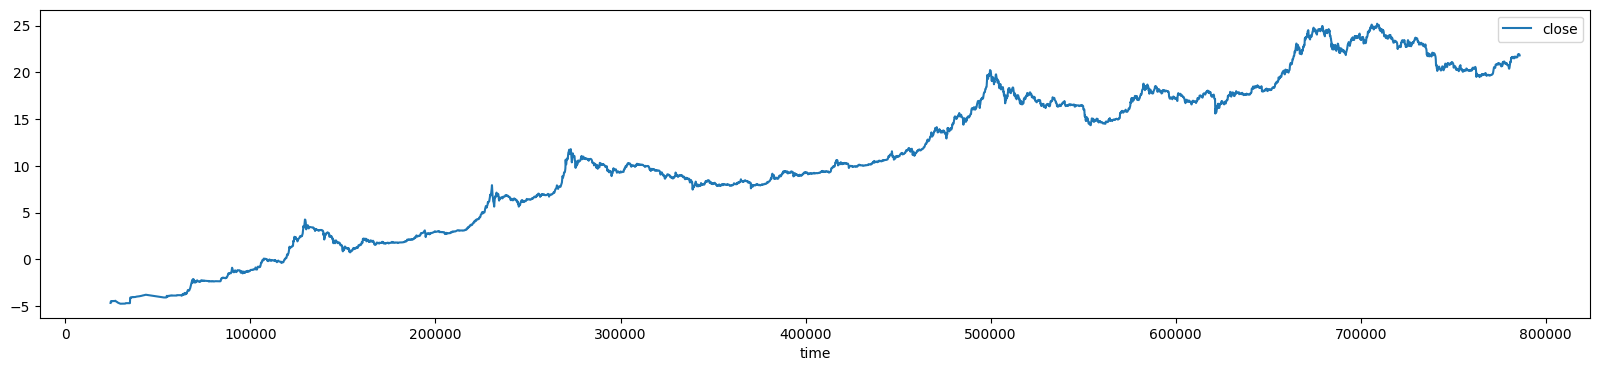

In [89]:
df_box.plot(kind='line', figsize = (20,4))

## LOWESS (Locally Weighted Scatterplot Smoothing)

Выделяем тренд вручную

In [90]:
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.tsa.stattools import adfuller

Подбираем frac чтобы в остатке был минимальные p-value в тесте Дики-Фуллера

In [91]:
pval = {}
"""
for i in range(60,101):
    trend = pd.DataFrame(lowess(df_wbox['close'], df_wbox.index, frac=i/100, it=3, return_sorted=False))
    # trend.plot(kind='line')
    trend.set_index(df_wbox.index, inplace=True)
    df_wbox_t = df_wbox.copy()
    df_wbox_t['close'] = (df_wbox['close'] - trend[0])
    # df_wbox_t.plot(kind='line')


    result = adfuller(df_wbox_t)
    # print('ADF Statistic:', result[0])
    # print('p-value:', result[1])
    # print('Critical Values:', result[4])
    print (i, result[1])
    if not result[1] is None:
        pval[i] = result[1]
        """


"\nfor i in range(60,101):\n    trend = pd.DataFrame(lowess(df_wbox['close'], df_wbox.index, frac=i/100, it=3, return_sorted=False))\n    # trend.plot(kind='line')\n    trend.set_index(df_wbox.index, inplace=True)\n    df_wbox_t = df_wbox.copy()\n    df_wbox_t['close'] = (df_wbox['close'] - trend[0])\n    # df_wbox_t.plot(kind='line')\n\n\n    result = adfuller(df_wbox_t)\n    # print('ADF Statistic:', result[0])\n    # print('p-value:', result[1])\n    # print('Critical Values:', result[4])\n    print (i, result[1])\n    if not result[1] is None:\n        pval[i] = result[1]\n        "

In [92]:
# min_val = min(pval.values())
# min_key = list(pval.keys())[list(pval.values()).index(min_val)]
# print(min_key)

ADF Statistic: -1.5885636163616357
p-value: 0.48933581534244625
Critical Values: {'1%': -3.4317096824174698, '5%': -2.862140827434085, '10%': -2.5670898220592187}


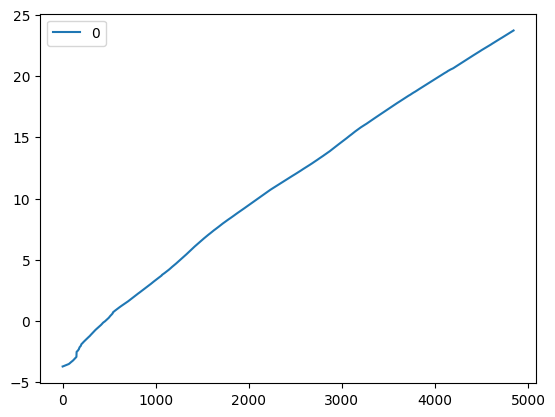

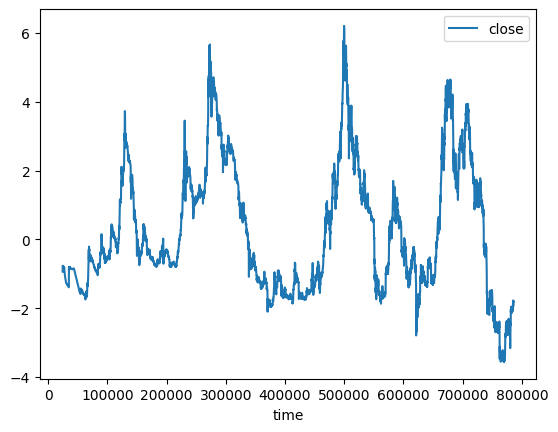

In [93]:
trend = pd.DataFrame(lowess(df_box['close'], df_box.index, frac=0.7, it=4, return_sorted=False))
trend.plot(kind='line')
trend.set_index(df_box.index, inplace=True)
df_cycle = df_box.copy()
df_cycle['close'] = (df_box['close'] - trend[0])
df_cycle.plot(kind='line')


result = adfuller(df_box)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

## Заполнение пропусков и изменение шага индексации

Можно увилеть что в начале много пропусков, т.к. отсутствует вся информация о количестве блоков в истории, пропуски необходимо заполнить. Используем метод bfill  
Также сейчас в качестве индекса ряд с неравномерным периодом, необходимо это исправить  

На данный момент история за 210000 * 3 + 155867 блоков  
Часть информации отсутствует в начале, часть блоков отсутствует в конце последнего цикла т.к. он ещё не завершился  
Чтобы сделать ряд равномерным сгруппируем данные по более крупному периоду, один шаг индексации будет равен 1000 блоков.

In [94]:
print(f'данные нужно разделить на {round((210000*3 + 155867)/1000)} бинов')

данные нужно разделить на 786 бинов


Обрезаем ряд до значения кратного 1000

In [95]:
df_cycle = df_cycle[0:785000]

Заполним пропуски после детренда ряда

In [96]:
# добавляем новую строку в начало датафрейма
new_row = pd.DataFrame({'close': [None], 'time': [0.0]})
new_row = new_row.set_index('time', drop=True)

df_cycle = pd.concat([new_row, df_cycle], axis=0)


<AxesSubplot:>

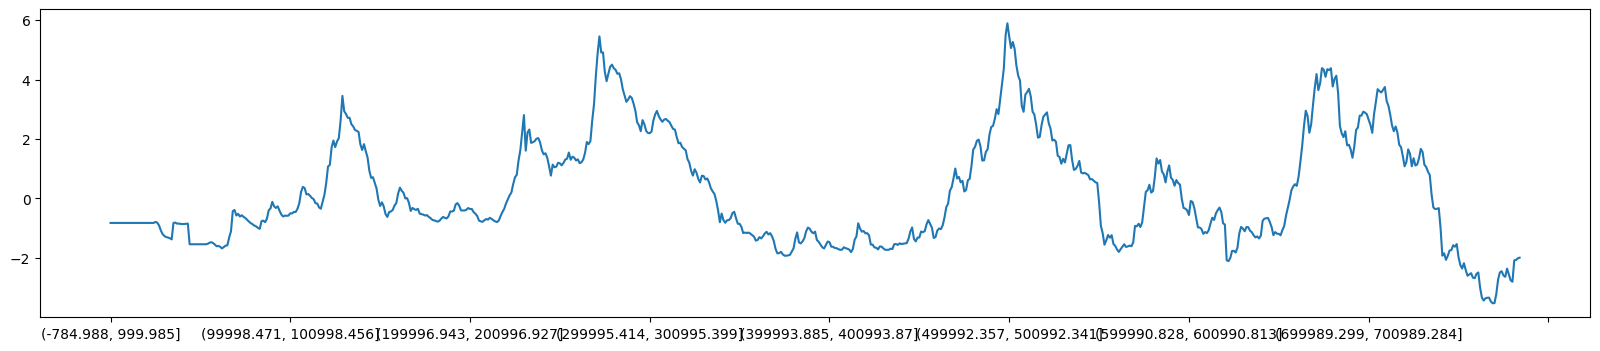

In [97]:
# Разбиваем индекс на батчи
batches = pd.cut(df_cycle.index, bins=round((785000)/1000))

# Группируем значения по батчам и применяем агрегирующую функцию mean
grouped = df_cycle.groupby(batches)['close'].mean()

#Один шаг индекса соответствует 100 блоков
#Заполняем пропуски в начале
grouped = grouped.fillna(method='bfill')
grouped.plot(kind='line', figsize = (20,4))

In [98]:
# сбрасываем индексы
df_g = grouped.reset_index(drop=True)
df_g

0     -0.824764
1     -0.824764
2     -0.824764
3     -0.824764
4     -0.824764
         ...   
780   -2.803303
781   -2.086730
782   -2.071099
783   -2.016313
784   -1.994707
Name: close, Length: 785, dtype: float64

## Автокорреляция

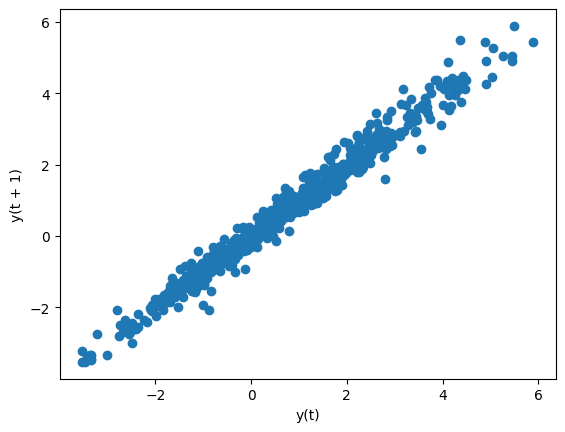

In [99]:
from matplotlib import pyplot
from pandas.plotting import lag_plot
lag_plot(df_g,1)
pyplot.show()

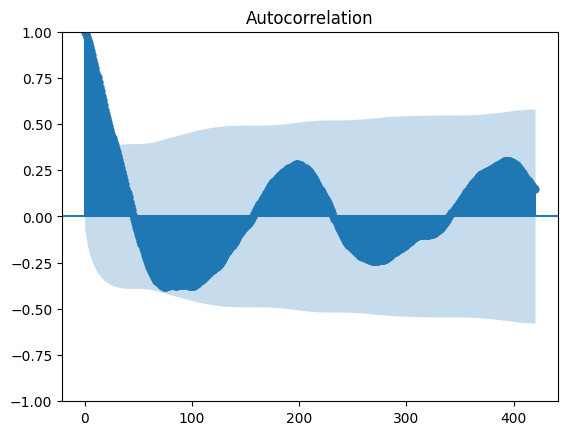

In [100]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df_g, lags=420)
pyplot.show()

c:\Users\danii\anaconda3\envs\practicum\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


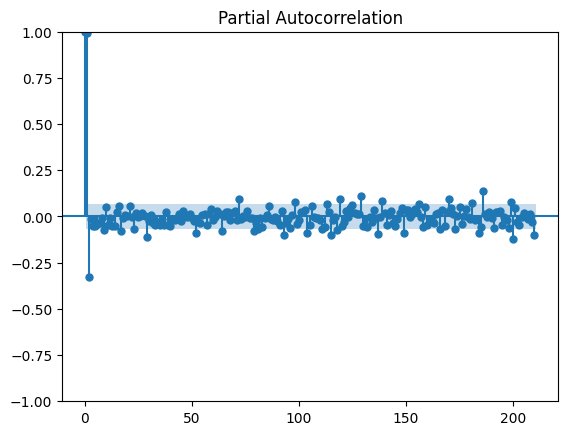

In [101]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df_g, lags=210)
pyplot.show()

## Определение цикличности с плавающим периодом

Разделим временной на каждом 210 000 блоке, в момент халвинга

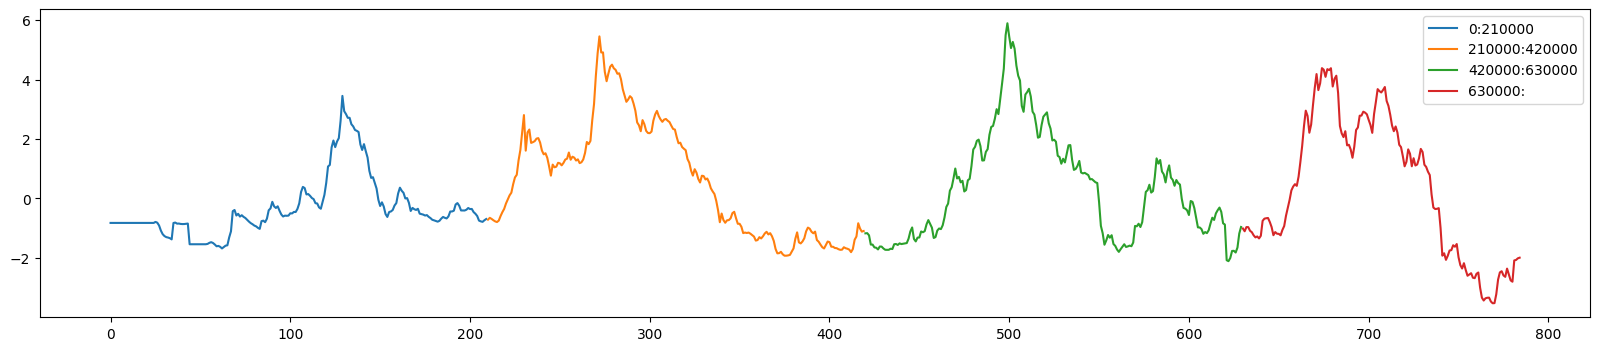

In [102]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

df_g[0:210].plot(kind='line', ax=ax, figsize = (20,4))
df_g[210:420].plot(kind='line', ax=ax, figsize = (20,4))
df_g[420:630].plot(kind='line', ax=ax, figsize = (20,4))
df_g[630:].plot(kind='line', ax=ax, figsize = (20,4))

# добавляем легенду
ax.legend(['0:210000', '210000:420000', '420000:630000', '630000:'])
plt.show()


In [103]:
# разделяем выборку и вычитаем начальную дату и время из индекса каждого периода
df_t1 = df_g[0:210]
df_t1.index = df_t1.index
df_t2 = df_g[210:420]
df_t2.index = df_t2.index - 210
df_t3 = df_g[420:630]
df_t3.index = df_t3.index - 420
df_t4 = df_g[630:]
df_t4.index = df_t4.index - 630

In [104]:
df_all = pd.DataFrame(df_t1.copy())
# делим значения первого цикла пополам чтобы уменьшить влияние на среднее
df_all['close'] = df_all['close']/2
df_all['close2'] = df_t2
df_all['close3'] = df_t3
df_all['close4'] = df_t4

In [105]:
df_all

,close,close2,close3,close4
0,-0.412382,-0.714674,-1.175147,-1.011178
1,-0.412382,-0.653806,-1.169363,-1.105448
2,-0.412382,-0.689725,-1.242521,-0.964329
3,-0.412382,-0.734413,-1.553614,-0.966924
4,-0.412382,-0.773220,-1.554555,-1.089563
...,...,...,...,...
205,-0.373389,-1.282019,-1.763577,NaN
206,-0.386363,-0.835848,-1.820623,NaN
207,-0.394187,-1.014410,-1.653652,NaN
208,-0.367574,-1.118193,-1.182530,NaN


In [106]:
df_mean = df_all.fillna(method='ffill').mean(axis=1)

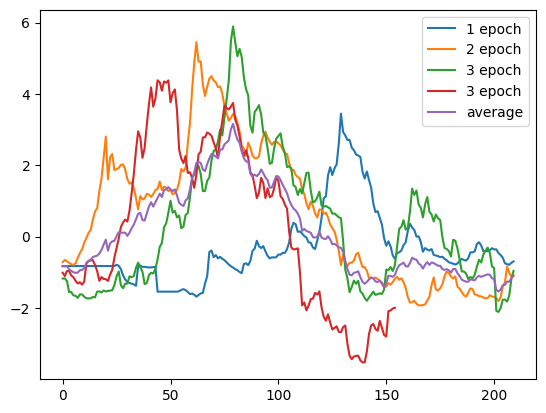

In [107]:

# создаем объект Axes
fig, ax = plt.subplots()

# наложение графиков на один график
df_t1.plot(kind='line', ax=ax)
df_t2.plot(kind='line', ax=ax)
df_t3.plot(kind='line', ax=ax)
df_t4.plot(kind='line', ax=ax)
df_mean.plot(kind='line', ax=ax)

# добавление легенды
ax.legend(['1 epoch', '2 epoch', '3 epoch', '3 epoch','average'])

# показать график
plt.show()


<AxesSubplot:>

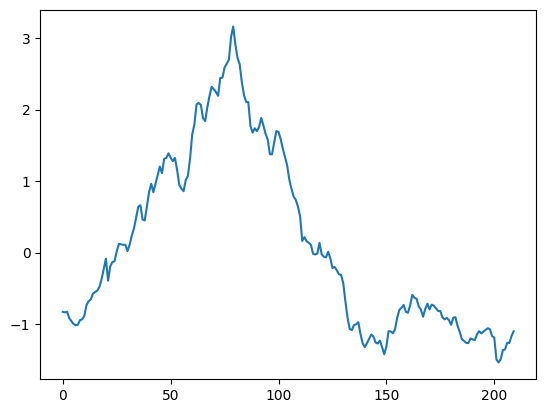

In [108]:
df_mean.plot(kind='line')

Продублируем циклы и вычтем из временного ряда с детрендом

In [109]:
df_mean_full = np.tile(df_mean, 4)

In [110]:
df_mean_full

array([-0.82834529, -0.83524978, -0.82723918, -0.91683318, -0.95742979,
       -0.99850467, -1.01523167, -1.0088945 , -0.94350813, -0.93362921,
       -0.88163925, -0.7329252 , -0.6807654 , -0.65423688, -0.57217433,
       -0.55129191, -0.53131172, -0.47724446, -0.37174095, -0.22456822,
       -0.084497  , -0.39288792, -0.19243294, -0.13187011, -0.12073209,
        0.01628566,  0.12239542,  0.11530633,  0.10977402,  0.10941771,
        0.02195289,  0.11264728,  0.23726588,  0.33929377,  0.48570643,
        0.64375791,  0.66188787,  0.46217683,  0.45019037,  0.64963494,
        0.84614926,  0.96318578,  0.84439085,  0.96363893,  1.07694642,
        1.20337642,  1.11152712,  1.31090765,  1.32306736,  1.38883572,
        1.32903102,  1.27798626,  1.32438287,  1.15589308,  0.94904301,
        0.89329237,  0.85855164,  1.01428177,  1.07350931,  1.31556805,
        1.65161932,  1.79237444,  2.07243665,  2.09303392,  2.06623859,
        1.88155702,  1.83842814,  2.03286569,  2.19004131,  2.31

<AxesSubplot:>

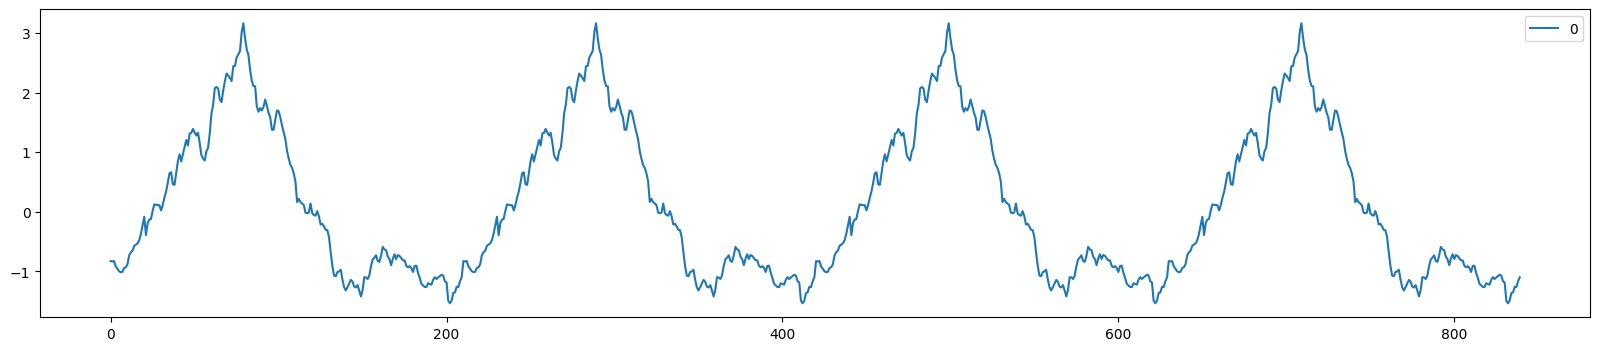

In [111]:
df_mean_full = pd.DataFrame(df_mean_full)[:785000]
df_mean_full.plot(kind = 'line', figsize = (20,4))

Вычтем сезоны

In [112]:
df_mean_full = df_mean_full.rename(columns={0: 'close'})

In [113]:
df_residual = pd.DataFrame(df_g) - df_mean_full
df_residual = df_residual.dropna()

<AxesSubplot:>

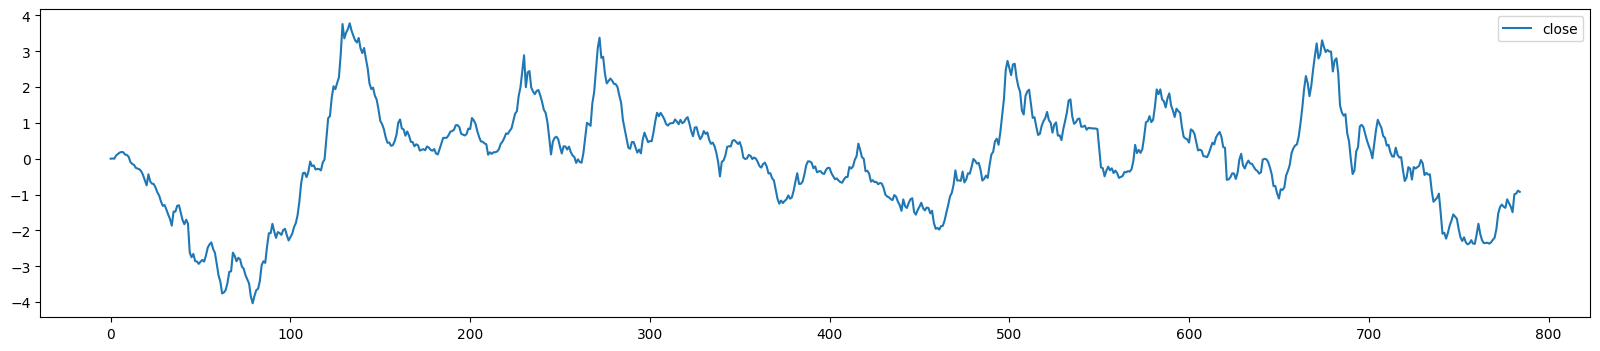

In [114]:
df_residual.plot(kind='line', figsize = (20,4))

In [115]:
# decomposed = seasonal_decompose(df_residual['close'])
# decomposed.trend.plot()
# from statsmodels.tsa.seasonal import STL
# stl_kwargs = {"seasonal_deg": 0} 
# model = STL(df_residual, trend_jump=1000, period=48)
# res = model.fit()
# res.plot()
# decomposed.seasonal.plot()
# decomposed.resid.plot()